# Dataset A Thaliana

## Übersicht

In diesem Notebook geht es darum den Datensatz von A Thaliana zu analysieren, bevor das Clustering durchgeführt wird. 

Die AAC wird berechnet und auf Outlier überprüft, anschließend wird ein simples Machine Learning Modell trainiert um die Performance zu schätzen. 

Die Performance von PAAC und PSSM sollte korrelieren mit der von AAC, für die Optimierung von COEXP ist wahrscheinlich eine getrennte Analyse nötig.

Ich denke es ist am besten, für A Thaliana alles komplett fertig zu stellen, und dann das selbe mit den anderen Organismen zu machen. An mehreren Organismen gleichzeitig zu arbeiten wäre umständlicher.


## Imports

In [1]:
import os
import sys
import shutil

sys.path.append('../src')
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC, LinearSVC
from sklearn.feature_selection import SelectKBest
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import f1_score
from sklearn.neighbors import KNeighborsClassifier

import matplotlib.pyplot as plt

from yellowbrick.features import ParallelCoordinates
from yellowbrick.features import Rank1D, Rank2D

import pandas as pd
import seaborn as sns

from dataset.transporter_dataset import create_dataset
from dataset.cluster_fasta import cd_hit
from features.labels import fasta_to_labels
from features.compositions import calculate_composition_feature
from features.pssm import calculate_pssm_feature
from features.coexp import calculate_coexp_feature
from models.eval import nested_crossval
from visualization.feature_plots import create_plot

## Globals

In [2]:
LOG_FILE = "../logs/athaliana_amino_sugar.log"
N_THREADS = 12

## 1. Creating the dataset

### Filtering (Keywords, Organismus)

In [3]:
# Delete previous log
if os.path.exists(LOG_FILE):
    with open(LOG_FILE, 'w'):
        pass

create_dataset(
    keywords_substrate_filter = ["Amino-acid transport","Sugar transport"],
    keywords_component_filter = ["Transmembrane"],
    keywords_transport_filter = ["Transport"],
    input_file = "../data/raw/swissprot/uniprot-reviewed_yes.tab.gz",
    multi_substrate = "remove",
    verbose = True,
    tax_ids_filter = [3702],
    output_tsv = "../data/datasets/athaliana_amino_sugar.tsv",
    output_fasta = "../data/datasets/athaliana_amino_sugar.fasta",
    output_log = LOG_FILE,
)

,keywords_transport,keywords_location,keywords_transport_related,gene_names,protein_names,tcdb_id,organism_id,sequence
Uniprot,,,,,,,,
Q9SFG0,Sugar transport,Membrane;Transmembrane,Symport;Transport,STP6 At3g05960 F2O10.8,Sugar transport protein 6 (Hexose transporter 6),2.A.1.1.56,3702,MAVVVSNANAPAFEAKMTVYVFICVMIAAVGGLIFGYDIGISGGVS...
Q9ZVK6,Sugar transport,Cell membrane;Membrane;Transmembrane,Symport;Transport,SUC8 At2g14670 T6B13.9,Sucrose transport protein SUC8 (Sucrose permea...,NaN,3702,MSDLQAKNDVVAVDRQSSSSLADLDGPSPLRKMISVASIAAGIQFG...
Q84WN3,Sugar transport,Membrane;Transmembrane,Transport,SWEET17 At4g15920 dl4000c FCAALL.237,Bidirectional sugar transporter SWEET17 (AtSWE...,NaN,3702,MAEASFYIGVIGNVISVLVFLSPVETFWKIVKRRSTEEYKSLPYIC...
O04249,Sugar transport,Cell membrane;Membrane;Transmembrane,Symport;Transport,STP7 At4g02050 AGAA.1 T10M13.6,Sugar transport protein 7 (Hexose transporter 7),NaN,3702,MAGGSFGPTGVAKERAEQYQGKVTSYVIIACLVAAIGGSIFGYDIG...
Q56ZZ7,Sugar transport,Membrane;Plastid inner membrane;Transmembrane,Transport,At5g16150 T21H19.70,Plastidic glucose transporter 4 (AtpGlcT),2.A.1.1.102,3702,MQSSTYAVKGNAAFAFQRRTFSSDRSTTSTGIRFAGYKSLATTGPL...
...,...,...,...,...,...,...,...,...
Q9FHH5,Amino-acid transport,Membrane;Transmembrane,Transport,GDU3 LBS1 At5g57685 MRI1.4,Protein GLUTAMINE DUMPER 3 (Protein LESS SUSCE...,NaN,3702,MEGRQYYPPRENVEGNRTTMGGGPHSPWHSPVPYLFGGLAAMLGLI...
Q8S8A0,Amino-acid transport,Membrane;Transmembrane,Transport,GDU4 At2g24762 F27A10.11,Protein GLUTAMINE DUMPER 4,NaN,3702,MRPLSIKPTSLDVARHATSVESFGNHRPPISPWHSPVPYLFGGLAA...
Q3E965,Amino-acid transport,Membrane;Transmembrane,Transport,GDU5 At5g24920 F6A4.130,Protein GLUTAMINE DUMPER 5,NaN,3702,MRQFPSIRGNINEKMMTTMVESQTRSPWRTPVPYLFGGLAAMLGLI...


### Creating a table of GO/Keyword annotations

TODO: Wenn nötig dann Keywords und GO terms zu Tabelle hinzufügen

In [4]:
df_annotations = pd.read_table("../data/datasets/athaliana_amino_sugar.tsv", index_col=0)
df_annotations.head()

,keywords_transport,keywords_location,keywords_transport_related,gene_names,protein_names,tcdb_id,organism_id,sequence
Uniprot,,,,,,,,
Q9SFG0,Sugar transport,Membrane;Transmembrane,Symport;Transport,STP6 At3g05960 F2O10.8,Sugar transport protein 6 (Hexose transporter 6),2.A.1.1.56,3702,MAVVVSNANAPAFEAKMTVYVFICVMIAAVGGLIFGYDIGISGGVS...
Q9ZVK6,Sugar transport,Cell membrane;Membrane;Transmembrane,Symport;Transport,SUC8 At2g14670 T6B13.9,Sucrose transport protein SUC8 (Sucrose permea...,NaN,3702,MSDLQAKNDVVAVDRQSSSSLADLDGPSPLRKMISVASIAAGIQFG...
Q84WN3,Sugar transport,Membrane;Transmembrane,Transport,SWEET17 At4g15920 dl4000c FCAALL.237,Bidirectional sugar transporter SWEET17 (AtSWE...,NaN,3702,MAEASFYIGVIGNVISVLVFLSPVETFWKIVKRRSTEEYKSLPYIC...
O04249,Sugar transport,Cell membrane;Membrane;Transmembrane,Symport;Transport,STP7 At4g02050 AGAA.1 T10M13.6,Sugar transport protein 7 (Hexose transporter 7),NaN,3702,MAGGSFGPTGVAKERAEQYQGKVTSYVIIACLVAAIGGSIFGYDIG...
Q56ZZ7,Sugar transport,Membrane;Plastid inner membrane;Transmembrane,Transport,At5g16150 T21H19.70,Plastidic glucose transporter 4 (AtpGlcT),2.A.1.1.102,3702,MQSSTYAVKGNAAFAFQRRTFSSDRSTTSTGIRFAGYKSLATTGPL...


In [5]:
df_annotations.keywords_transport.value_counts()

Sugar transport         118
Amino-acid transport     54
Name: keywords_transport, dtype: int64

In [6]:
df_locations = pd.DataFrame(df_annotations.keywords_location.copy())
df_locations["location"] = df_locations.keywords_location.str.split(";")
df_locations = df_locations.drop("keywords_location", axis=1).explode(
    "location"
)  # .rename(columns = {"keywords_location": "location"})
df_locations = df_locations.reset_index()

df_locations.location.value_counts()


Membrane                  172
Transmembrane             172
Cell membrane              54
Endoplasmic reticulum       8
Mitochondrion               2
Plastid inner membrane      1
Nucleus                     1
Name: location, dtype: int64

### Which proteins are not annotated with a specific membrane?

Es handelt sich um die Outlier, andere sind laut GO terms in Plasmamembran (stichprobe)

In [7]:
df_annotations[df_annotations.keywords_location == "Membrane;Transmembrane"]

,keywords_transport,keywords_location,keywords_transport_related,gene_names,protein_names,tcdb_id,organism_id,sequence
Uniprot,,,,,,,,
Q9SFG0,Sugar transport,Membrane;Transmembrane,Symport;Transport,STP6 At3g05960 F2O10.8,Sugar transport protein 6 (Hexose transporter 6),2.A.1.1.56,3702,MAVVVSNANAPAFEAKMTVYVFICVMIAAVGGLIFGYDIGISGGVS...
Q84WN3,Sugar transport,Membrane;Transmembrane,Transport,SWEET17 At4g15920 dl4000c FCAALL.237,Bidirectional sugar transporter SWEET17 (AtSWE...,NaN,3702,MAEASFYIGVIGNVISVLVFLSPVETFWKIVKRRSTEEYKSLPYIC...
Q8H184,Sugar transport,Membrane;Transmembrane,Transport,At1g06470 F12K11.18,Probable sugar phosphate/phosphate translocato...,NaN,3702,MEQRVQLRVGTMETISNEGDVDREQVLETFGIENETGKETNGSRSF...
Q8L7R8,Sugar transport,Membrane;Transmembrane,Symport;Transport,STP3 At5g61520 K11J9_40,Sugar transport protein 3 (Hexose transporter 3),NaN,3702,MVAEEARKEAMAKSVSGGKITYFVVASCVMAAMGGVIFGYDIGVSG...
Q9LT15,Sugar transport,Membrane;Transmembrane,Symport;Transport,STP10 At3g19940 MPN9.19,Sugar transport protein 10 (Hexose transporter...,2.A.1.1.124,3702,MAGGAFVSEGGGGGRSYEGGVTAFVIMTCIVAAMGGLLFGYDLGIS...
...,...,...,...,...,...,...,...,...
Q9FHH5,Amino-acid transport,Membrane;Transmembrane,Transport,GDU3 LBS1 At5g57685 MRI1.4,Protein GLUTAMINE DUMPER 3 (Protein LESS SUSCE...,NaN,3702,MEGRQYYPPRENVEGNRTTMGGGPHSPWHSPVPYLFGGLAAMLGLI...
Q8S8A0,Amino-acid transport,Membrane;Transmembrane,Transport,GDU4 At2g24762 F27A10.11,Protein GLUTAMINE DUMPER 4,NaN,3702,MRPLSIKPTSLDVARHATSVESFGNHRPPISPWHSPVPYLFGGLAA...
Q3E965,Amino-acid transport,Membrane;Transmembrane,Transport,GDU5 At5g24920 F6A4.130,Protein GLUTAMINE DUMPER 5,NaN,3702,MRQFPSIRGNINEKMMTTMVESQTRSPWRTPVPYLFGGLAAMLGLI...


### Clustering (for dataset analysis)

Der Vergleich von verschiedenen Clustering-Thresholds findet danach statt, in einem anderen Notebook

In [8]:
# if CLUSTERING != 100:
#     cd_hit(
#         executable_location="../bin/cd-hit",
#         input_fasta="../data/datasets/athaliana_amino_sugar.fasta",
#         output_fasta=f"../data/datasets/athaliana_amino_sugar_cluster{CLUSTERING}.fasta",
#         log_file=LOG_FILE,
#         identity_threshold=CLUSTERING,
#         n_threads=N_THREADS,
#         memory=4096,
#         verbose=True,
#     )
# else:
shutil.copyfile("../data/datasets/athaliana_amino_sugar.fasta", "../data/datasets/athaliana_amino_sugar_cluster100.fasta")
# DATASET_FASTA = f"../data/datasets/athaliana_amino_sugar_cluster{CLUSTERING}.fasta"

'../data/datasets/athaliana_amino_sugar_cluster100.fasta'

## 2. Feature generation

### 2.1 Labels

In [9]:
fasta_to_labels(
    input_fasta="../data/datasets/athaliana_amino_sugar_cluster100.fasta",
    output_tsv="../data/features/athaliana_amino_sugar_cluster100_labels.tsv"
)
pd.read_table("../data/features/athaliana_amino_sugar_cluster100_labels.tsv", index_col=0).labels.value_counts()

Sugar transport         118
Amino-acid transport     54
Name: labels, dtype: int64

### 2.2 AAC, PAAC

In [10]:
calculate_composition_feature(
    input_fasta="../data/datasets/athaliana_amino_sugar_cluster100.fasta",
    output_tsv=f"../data/features/athaliana_amino_sugar_cluster100_aac.tsv",
    feature_type="aac",
)


## 3. Feature visualization (AAC, Clustering 100)

### 3.1 Clustermap

Die Clustermap zeigt, dass die 20 Features sich eindeutig in zwei Cluster einteilen lassen, eins mit häufigen Aminosäuren und eins mit weniger häufigen. 

Features:

- Bei den häufigen Aminosäuren sticht vorallem Leucin hervor
- Bei den weniger häüfigen gibt es vier mit praktisch kaum vorhandenen Aminosäuren.
- Um festzustellen, ob dieses Muster typisch für Transporter ist, oder für dieses Substrate, müsste man den selben Plot für andere Datensätze erstellen.

Samples:

- Die Substrate sind durch HClustering nicht eindeutig zuweißbar.
- Könnte auf komplexeres Modell hinweisen, dass 3 oder mehr Dimensionen braucht

{'Sugar transport': 'red', 'Amino-acid transport': 'green'}


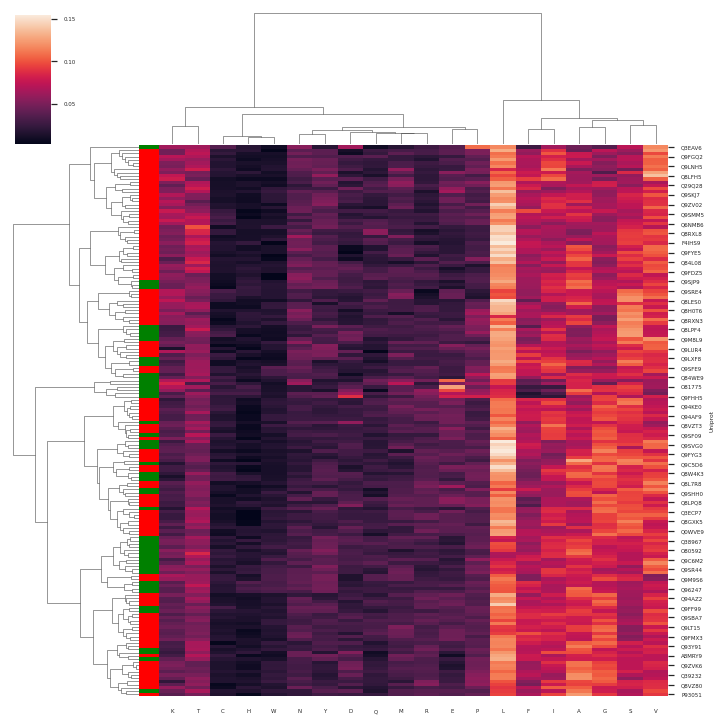

In [11]:
create_plot(
    input_features="../data/features/athaliana_amino_sugar_cluster100_aac.tsv",
    input_labels="../data/features/athaliana_amino_sugar_cluster100_labels.tsv",
    log_file=LOG_FILE,
    type="sample",
    verbose=True,
)

### 3.2 Korrelation der Proteine

Dies ist eine Heatmap mit Ward-clustering von den Proteinen. 

- Man sieht rechts ein großes Cluster aus Zucker-Transportern, in dem sich nur wenige Amino-Transporter befinden. 
- Links ist ein kleines Amino-Cluster, dass sich sehr start von allen anderen Protein unterscheidet.
- In der Mitte ist ein gemischtes Cluster, das Größte.
- Als nächstes sollte ich die Korrelationen auslesen, und die Tabelle aus Transportern danach filtern. Dann finde ich evtl. durch Keywords herraus, was diese Cluster jeweils gemeinsam haben.

{'Sugar transport': 'red', 'Amino-acid transport': 'green'}


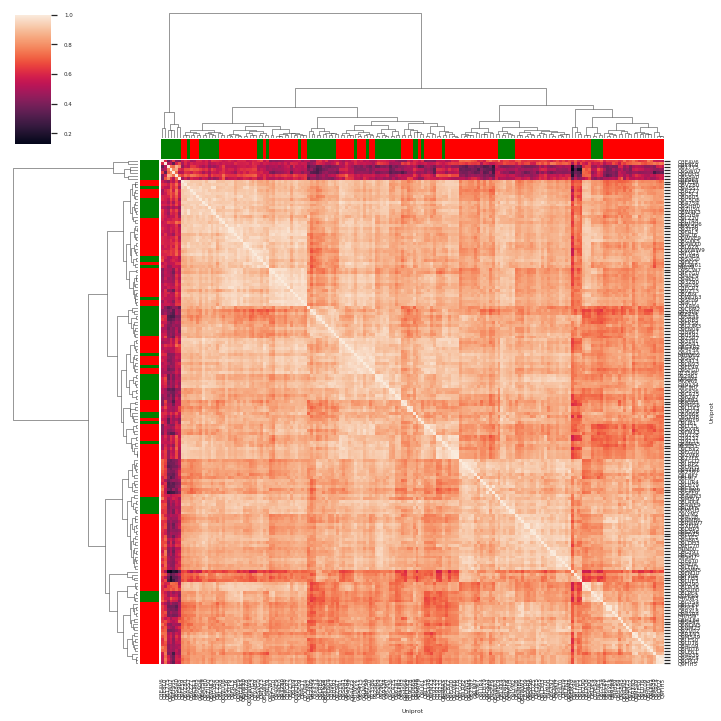

In [12]:
create_plot(
    input_features="../data/features/athaliana_amino_sugar_cluster100_aac.tsv",
    input_labels="../data/features/athaliana_amino_sugar_cluster100_labels.tsv",
    log_file=LOG_FILE,
    type="corr_samples",
    verbose=True
)
plt.savefig("plots/athaliana_sugar_amino_cluster100_clustermap_outliers",dpi=300)

### Zu Heatmap 3.2: Welche Proteine sind in dem kleinen Cluster?

Das kleine Cluster aus AA transportern, die sehr niedrige Korrelation zum restlichen Datensatz haben, scheinen zur selben Familie zu gehören. Einer dieser Transporter (GDU1) ist laut TCDB (1.A.41.2.2) ein Kanal, und passiver Glutamin-Transporter.

Laut https://pubmed.ncbi.nlm.nih.gov/20018597/: Each of the seven Arabidopsis (Arabidopsis thaliana) GDU genes led to similar phenotypes, including increased efflux of a wide spectrum of amino acids. Differences in expression profiles and functional properties suggested that the GDU genes fulfill different roles in roots, vasculature, and reproductive organs.

,keywords_transport,keywords_location,keywords_transport_related,gene_names,protein_names,tcdb_id,organism_id,sequence
Uniprot,,,,,,,,
O81775,Amino-acid transport,Cell membrane;Membrane;Transmembrane,Transport,GDU1 At4g31730 F28M20.80,Protein GLUTAMINE DUMPER 1,1.A.41.2.2,3702,MRPLSVQSKFEDVATSTSVNHHGVTPQSPWHSPVPYLFGGLAAMLG...
Q9SW07,Amino-acid transport,Membrane;Transmembrane,Transport,GDU2 At4g25760 F14M19.40,Protein GLUTAMINE DUMPER 2,NaN,3702,MQTMEGRQYNYQDSINASSSMVVPHSPWHSPVPYLFGGLAAMLALI...
Q9FHH5,Amino-acid transport,Membrane;Transmembrane,Transport,GDU3 LBS1 At5g57685 MRI1.4,Protein GLUTAMINE DUMPER 3 (Protein LESS SUSCE...,NaN,3702,MEGRQYYPPRENVEGNRTTMGGGPHSPWHSPVPYLFGGLAAMLGLI...
Q8S8A0,Amino-acid transport,Membrane;Transmembrane,Transport,GDU4 At2g24762 F27A10.11,Protein GLUTAMINE DUMPER 4,NaN,3702,MRPLSIKPTSLDVARHATSVESFGNHRPPISPWHSPVPYLFGGLAA...
Q3E965,Amino-acid transport,Membrane;Transmembrane,Transport,GDU5 At5g24920 F6A4.130,Protein GLUTAMINE DUMPER 5,NaN,3702,MRQFPSIRGNINEKMMTTMVESQTRSPWRTPVPYLFGGLAAMLGLI...
Q3E8L0,Amino-acid transport,Membrane;Transmembrane,Transport,GDU7 At5g38770 MKD10.70,Protein GLUTAMINE DUMPER 7,NaN,3702,MSLHRDSMVPVNSRLENMDSPILSKICAWGVMLGLFALSLFAMAYA...


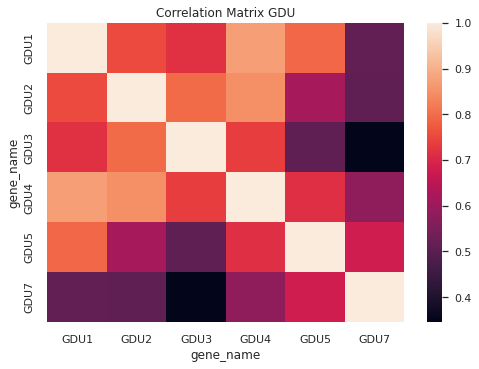

In [13]:
from sklearn.cluster import KMeans

df_aac = pd.read_table(
    f"../data/features/athaliana_amino_sugar_cluster100_aac.tsv", index_col=0
)
kmeans = KMeans(n_clusters=3, random_state=1)
kmeans.fit(df_aac.copy())

# https://www.uniprot.org/uniprot/O81775
# https://tcdb.org/search/result.php?tc=1.A.41

df_outliers_aa = df_annotations.loc[df_aac[kmeans.labels_ == 2].index]
df_aac_outliers_aa = df_aac.loc[df_outliers_aa.index]
df_aac_outliers_aa["gene_name"] = df_outliers_aa.gene_names.str.split(expand=True)[0]
df_aac_outliers_aa = df_aac_outliers_aa.set_index("gene_name")

g = sns.heatmap(
    data=df_aac_outliers_aa.transpose().corr("pearson"),
)
g.set_title("Correlation Matrix GDU")
df_outliers_aa


### TCDB IDs in Datensatz

Nach Entfernen der Outlier sind nur noch Proteine aus TCDB Klasse 2.A (Porter), sowie Proteine ohne TCDB Klasse im Datensatz:

In [14]:
df_annotations.fillna("Nan").tcdb_id.apply(lambda s: s[0:3]).value_counts()

Nan    114
2.A     57
1.A      1
Name: tcdb_id, dtype: int64

### 3.3 Korrelation der Features

- Nur wenige Features haben eine hohe Korrelation zueinander im gesamten Datensatz
- Das ändert sich etwas, wenn man Features nur von einer Transporter-Klasse anguckt (Plots 2 und 3)
- Schlussfolgerung: 
    - PCA mit wenigen Komponenten verliert viel zu Information.

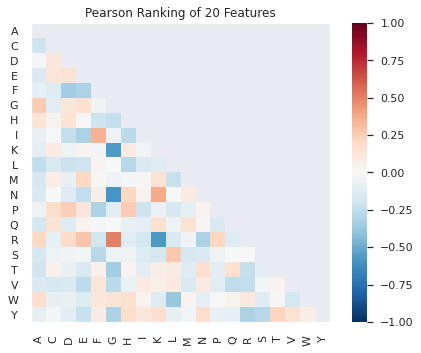

<AxesSubplot:title={'center':'Pearson Ranking of 20 Features'}>

In [15]:
df_aac = pd.read_table(
    "../data/features/athaliana_amino_sugar_cluster100_aac.tsv", index_col=0
)
df_labels = pd.read_table(
    "../data/features/athaliana_amino_sugar_cluster100_labels.tsv", index_col=0
)
r2d = Rank2D(algorithm="pearson")
r2d.fit_transform(df_aac, df_labels.labels)
r2d.show()

#### Nur AA transporter

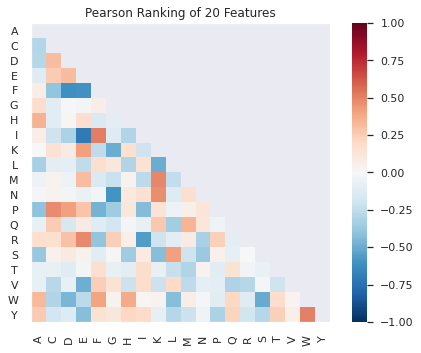

<AxesSubplot:title={'center':'Pearson Ranking of 20 Features'}>

In [16]:
mask_amino = df_labels.labels == "Amino-acid transport"
r2d = Rank2D(algorithm='pearson')
r2d.fit_transform(df_aac.loc[mask_amino], df_labels.loc[mask_amino].labels)
r2d.show()

#### Nur Sugar transporter

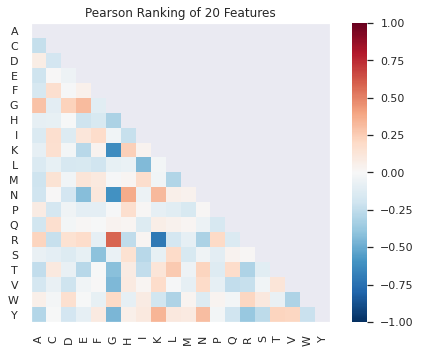

<AxesSubplot:title={'center':'Pearson Ranking of 20 Features'}>

In [17]:
mask_sugar = df_labels.labels == "Sugar transport"
r2d = Rank2D(algorithm='pearson')
r2d.fit_transform(df_aac.loc[mask_sugar], df_labels.loc[mask_sugar].labels)
r2d.show()

### 3.4 Folgen die AAC Features einer Normalverteilung?

- Wahrscheinlichkeit, dass Sample aus Normalverteilung stammt
- Größtenteils ja, außer Glutaminsäure und Prolin etwas weniger
- Bei Betrachtung der Verteilung wird klar, dass es 2 bzw. 4 Proteine mit deutliche höherem Glu/Pro Anteil gibt. 
    - Sind diese auch Outlier auf der Clustermap? Haben sie Gemeinsamkeiten?

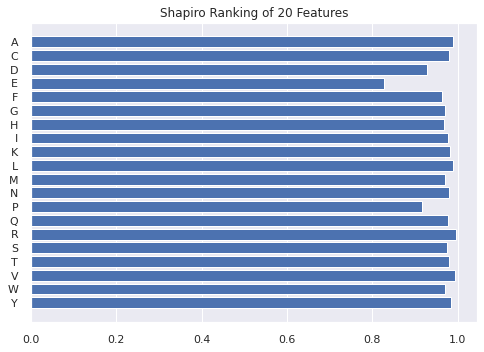

<AxesSubplot:title={'center':'Shapiro Ranking of 20 Features'}>

In [18]:
df_aac = pd.read_table(
    "../data/features/athaliana_amino_sugar_cluster100_aac.tsv", index_col=0
)
df_labels = pd.read_table(
    "../data/features/athaliana_amino_sugar_cluster100_labels.tsv", index_col=0
)
r2d = Rank1D(algorithm="shapiro")
r2d.fit_transform(df_aac, df_labels.labels)
plt.savefig("plots/athaliana_amino_sugar_outlier_shapiro.png", dpi=300)
r2d.show()


#### Verteilungen von P und E

Es fällt auf, dass es einige Outlier gibt mit ungewöhlich hohem P und E Anteil. Welche Proteine sind das?

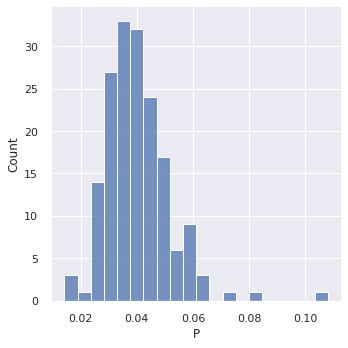

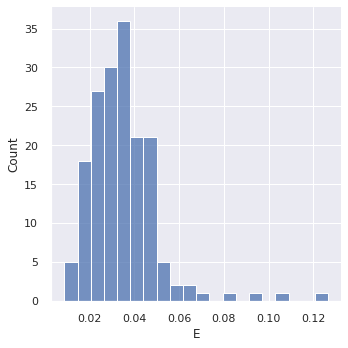

In [19]:
import seaborn as sns
sns.displot(df_aac.P)
plt.savefig("plots/athaliana_amino_sugar_outlier_p.png", dpi=300)
sns.displot(df_aac.E)
plt.savefig("plots/athaliana_amino_sugar_outlier_e.png", dpi=300)

#### Proteine mit hohen P 

Die letzte Spalte enthält jeweils die AAC. 

Mögliche Outlier: 
- GDU 3 und 6:
    - GDU 1-5 und 7 waren schon bei der Heatmap weiter oben Outlier, 6 unterscheidet sich nun auch vom Rest des Datensatzes
- Lysine histidine transporter-like 8
    - Besitzt laut AlphaFold 11 Helices, getrennt durch kurze, Prolinhaltige Loops. 
    - BLAST + Clustal Omega
        - Am Anfang befindet sich ein stark konservierte Region im Cytoplasma, mit hoher Prolin, Serin und Threonin-Konzentration.
        - Phosphorilierung von Serin und Threonin verändert die 3D-Struktur, es könnte sich um eine Art Tür/Scharnier handeln?
        - Danach Helices, getrennt durch Prolin-haltige loops

In [20]:
df_annotations.loc[df_aac[df_aac.P > 0.07].index].join(df_aac.P, how="left").drop("sequence", axis=1)

,keywords_transport,keywords_location,keywords_transport_related,gene_names,protein_names,tcdb_id,organism_id,P
Uniprot,,,,,,,,
Q9SX98,Amino-acid transport,Cell membrane;Membrane;Transmembrane,Transport,AATL1 At1g47670 F16N3.4,Lysine histidine transporter-like 8 (Amino aci...,2.A.18.2.8,3702,0.073218
Q9FHH5,Amino-acid transport,Membrane;Transmembrane,Transport,GDU3 LBS1 At5g57685 MRI1.4,Protein GLUTAMINE DUMPER 3 (Protein LESS SUSCE...,NaN,3702,0.081081
Q3EAV6,Amino-acid transport,Membrane;Transmembrane,Transport,GDU6 At3g30725 T4A2.7,Protein GLUTAMINE DUMPER 6,NaN,3702,0.108108


#### Proteine mit hohem E Anteil


- GLUTAMINE DUMPER (GDU) 1-5
    - GDU 1-5 und 7 waren schon bei der Heatmap weiter oben Outlier.
    - GDU Struktur Alphafold: Eine kurze Transmembranhelix, lange cytoplastische "disordered"-Domain
- Probable polyol transporter 4: 
    - Hat auf BLAST eine Identität von 98.7% zu einem MFS-Protein, also sehr wahrscheinlich TCDB Klasse 2.A.1
    - Struktur von AlphaFold 
        - Helix Barrel mit Domänen im Cytoplasma
        - Hohe Glutamat-Konzentration an zwei intrazellulären Helices. 
        - Wahrscheinlich ist Glu wichtig für Funktion.
- GDP-mannose transporter GONST3
    - Gehört zu einer Antiporter-Familie, die Nukleotide und Zucker über Golgi-Membran transportieren
    - GONST 1-5 sind auch im Datensatz
    - Gehören zur Drug/Metabolite Transporter Superfamily (2.A.7)
    - Alphafold: 
        - Hat lange, sehr Glutamat-Reiche "disordered region" am Ende, die nicht in der Membran verankert ist.
        - Wahrscheinlich wichtig für Funktion

In [21]:
df_annotations.loc[df_aac[df_aac.E > 0.06].index].join(df_aac.E, how="left").drop("sequence", axis=1)

,keywords_transport,keywords_location,keywords_transport_related,gene_names,protein_names,tcdb_id,organism_id,E
Uniprot,,,,,,,,
Q0WUU6,Sugar transport,Membrane;Transmembrane,Symport;Transport,PLT4 At2g20780 F5H14.25,Probable polyol transporter 4,NaN,3702,0.062738
Q9S845,Sugar transport,Membrane;Transmembrane,Antiport;Transport,GONST3 At1g76340 F15M4.16,GDP-mannose transporter GONST3 (Protein GOLGI ...,2.A.7.13.5,3702,0.064516
O81775,Amino-acid transport,Cell membrane;Membrane;Transmembrane,Transport,GDU1 At4g31730 F28M20.80,Protein GLUTAMINE DUMPER 1,1.A.41.2.2,3702,0.126582
Q9SW07,Amino-acid transport,Membrane;Transmembrane,Transport,GDU2 At4g25760 F14M19.40,Protein GLUTAMINE DUMPER 2,NaN,3702,0.069767
Q9FHH5,Amino-acid transport,Membrane;Transmembrane,Transport,GDU3 LBS1 At5g57685 MRI1.4,Protein GLUTAMINE DUMPER 3 (Protein LESS SUSCE...,NaN,3702,0.081081
Q8S8A0,Amino-acid transport,Membrane;Transmembrane,Transport,GDU4 At2g24762 F27A10.11,Protein GLUTAMINE DUMPER 4,NaN,3702,0.096154
Q3E965,Amino-acid transport,Membrane;Transmembrane,Transport,GDU5 At5g24920 F6A4.130,Protein GLUTAMINE DUMPER 5,NaN,3702,0.106870


#### Schlussfolgerung über Outlier

- Die 7 GDU Transporter sollten entfernt werden, da sie eine kleine Untermenge von Channels in einem Datensatz aus Carriern sind, und sich dementsprechend stark von dem restlichen Datensatz unterscheiden
- Die zwei Zucker-Transporter mit hohem Glu-Anteil sind keine Outlier, sie sind Porter bei denen stark konservierte Glu -haltige Regionen im Cytoplasma als Filter fungieren.
- Bei dem Lysin-Transporter mit hohem Pro-Anteil fungiert eine Pro/Ser/Thr Region evtl. als Tür-Mechanismus, auch kein Outlier.

### 3.5 Feature importance

Hier geht es darum, die Wichtigkeit der Features für die Klassifikation festzustellen. 

- Zuerst visuell, dann durch die ANOVA F-Scores zwischen features und labels (höher ist besser).
- Die Auftrennbarkeit der Features in Plot 1 scheint sich mit den F-Scores zu decken.
- Plot 3 zeigt die Verteilung der Features. Interessanterweise haben die besten Features niedrige Durschnittswerte und Standardabweichungen.

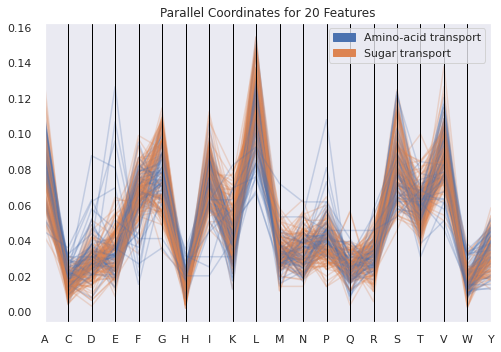

<AxesSubplot:>

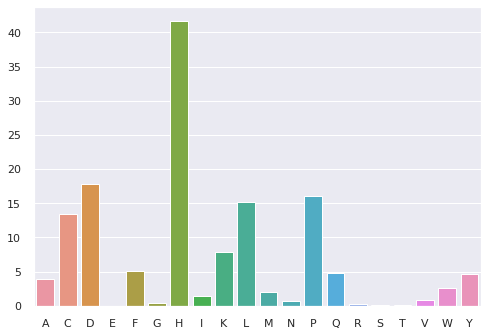

In [22]:
pc = ParallelCoordinates()

pc.fit_transform(df_aac, df_labels.labels)
pc.show()

skb = SelectKBest(k=20)
skb.fit(df_aac, df_labels.labels)
sns.barplot(x=df_aac.columns, y=skb.scores_)


### 3.6 Boxplots alle, amino, sugar

- Hier sieht man Unterschiede im Mittelwert bei den guten Features, allerdings auch Überschneidung
- Die guten Features zusammen könnten im 5-dimensionalen Raum für die guten SVM Ergebnisse sorgen.

<AxesSubplot:>

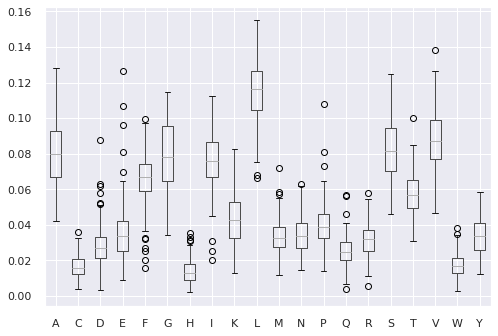

In [23]:
df_aac.boxplot()

<AxesSubplot:>

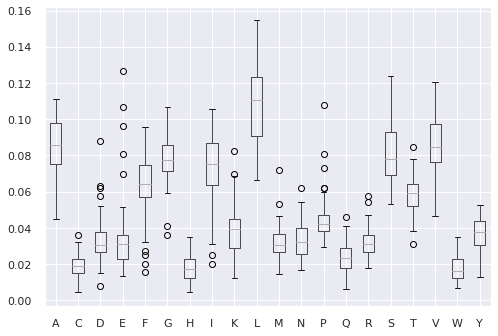

In [24]:
df_aac.loc[mask_amino].boxplot()

<AxesSubplot:>

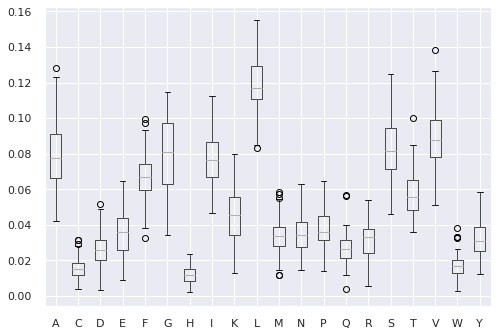

In [25]:
df_aac.loc[mask_sugar].boxplot()

### PCA Plots

Hier sind die PCA Plots, wegen denen ich die Analyse angefangen habe. Ich hatte mich gefragt, warum die SVM gut Ergebnisse liefert, obwohl der PCA plot so uneindeutig aussieht. 

Man sieht oben rechts wieder die Outliers mit hohem Prolin/Glutamat Anteil. 

**TODO sind das wirklich die gleichen?**

Bei dem 3D Plot sieht man, dass die Auftrennung schon etwas besser wird. 

Weiter unten wird sich zeigen, dass die lineare SVM erst im 3D Raum gute Scores liefert (f1>0.8).

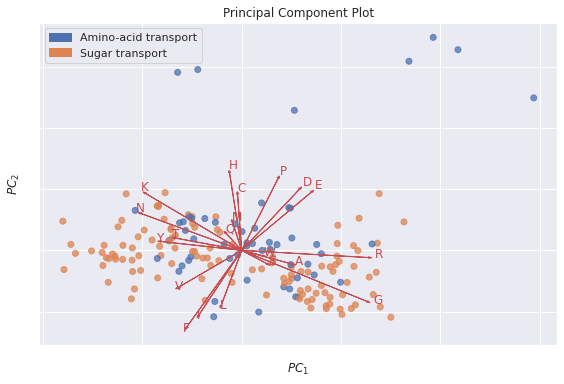

/home/ad/miniconda3/envs/subpred/lib/python3.9/site-packages/yellowbrick/features/pca.py:458: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  self.fig.tight_layout()


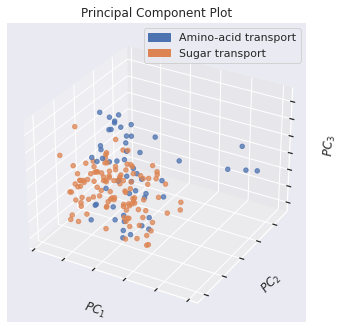

<Axes3DSubplot:title={'center':'Principal Component Plot'}, xlabel='$PC_1$', ylabel='$PC_2$'>

In [26]:
from yellowbrick.features import PCA as PCAPlot

df_aac = pd.read_table(
    "../data/features/athaliana_amino_sugar_cluster100_aac.tsv", index_col=0
)
df_labels = pd.read_table(
    "../data/features/athaliana_amino_sugar_cluster100_labels.tsv", index_col=0
)
le = LabelEncoder()
y = le.fit_transform(df_labels.labels.ravel())

pca_plot = PCAPlot(classes=le.classes_, scale=True, proj_features=True, features=df_aac.columns)
pca_plot.fit_transform(df_aac.to_numpy(), y)
pca_plot.show()

pca_plot = PCAPlot(classes=le.classes_, scale=True, features=df_aac.columns, projection=3)
pca_plot.fit_transform(df_aac.to_numpy(), y)
pca_plot.show()

## Model training A Thaliana AAC, no clustering

### Test: Does removing the outliers improve classification results?

Zum Test wurde Naive Bayes mit allen Features benutzt. 

- Die Trainings-Scores verbessern sich 
- Overfitting verringert sich (distanz zwischen training score und test score)
- Standardabweichung verringert sich auch

Das Entfernen der Outlier hat die Ergebnisse verbessert. 

Von hier an wird der Datensatz ohne die Outlier verwendet.

##### With outliers

In [27]:
df_aac_outliers = pd.read_table(
    "../data/features/athaliana_amino_sugar_cluster100_aac.tsv", index_col=0
)
df_labels_outliers = pd.read_table(
    "../data/features/athaliana_amino_sugar_cluster100_labels.tsv", index_col=0
)
X_outliers = df_aac_outliers.to_numpy()
label_encoder = LabelEncoder()
y_outliers = label_encoder.fit_transform(df_labels_outliers.to_numpy().ravel())
nested_crossval(
    X_outliers,
    y_outliers,
    params={},
    pipe=make_pipeline(StandardScaler(), GaussianNB()),
    scoring="f1_weighted",
)


,0,1,2,3,4,mean,std
test_score,0.806,0.529,0.731,0.76,0.685,0.702,0.106
train_score,0.829,0.860,0.845,0.82,0.925,0.856,0.042


##### Without outliers

In [28]:
# GLUTAMATE DUMPERS
outliers = ["O81775", "Q9SW07", "Q9FHH5", "Q8S8A0", "Q3E965", "Q3EAV6", "Q3E8L0"]
df_aac = df_aac_outliers.drop(outliers)
df_labels = df_labels_outliers.drop(outliers)

X = df_aac.to_numpy()
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df_labels.to_numpy().ravel())
nested_crossval(
    X, y, params={}, pipe=make_pipeline(StandardScaler(), GaussianNB()), scoring="f1_weighted"
)


,0,1,2,3,4,mean,std
test_score,0.846,0.734,0.810,0.840,0.879,0.822,0.055
train_score,0.915,0.939,0.907,0.923,0.906,0.918,0.014
